# Import

In [1]:
!nvidia-smi

import os
import sys
import cv2
import time
import random
import logging
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy import interp
import albumentations as A
from itertools import cycle
from sklearn import metrics
from IPython import display
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix as sk_cm
%matplotlib inline

Tue Aug 13 11:45:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Variables

In [2]:
class_to_num = {
    'Angry': 0,
    'Disgust': 1,
    'Fear': 2,
    'Happy': 3,
    'Sad': 4,
    'Surprise': 5,
    'Neutral': 6
}

num_to_class = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

NUM_CLASSES = len(num_to_class)

In [3]:
from myutilitymethods import MyMethods
from mycnn import MyCNN
from mydeepcnn import MyDeepCNN

Using TensorFlow backend.


In [4]:
mm = MyMethods(NUM_CLASSES, num_to_class, class_to_num)

# Methods

In [5]:
def plot_all_confusion_matrices(y_true, y_pred, y_true_val, y_pred_val, y_true_test, y_pred_test, 
                                classes, save_title, normalize=False, title=None, cmap='GnBu', dpi=150):
    '''Plot train, validation, and test confusion matrices'''
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrices'
        else:
            title = 'Non-Normalized Confusion Matrices'
    # Compute confusion matrix
    cm_train = sk_cm(y_true, y_pred)
    cm_val = sk_cm(y_true_val, y_pred_val)
    cm_test = sk_cm(y_true_test, y_pred_test)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize: 
        cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
        cm_val   = cm_val.astype('float')   / cm_val.sum(axis=1)  [:, np.newaxis]
        cm_test  = cm_test.astype('float')  / cm_test.sum(axis=1) [:, np.newaxis]
    # Lists  
    cms = [cm_train, cm_val, cm_test]
    titles = ['Train', 'Validation', 'Test']
    fig, axes = plt.subplots(nrows=1, ncols=3, dpi=dpi, figsize=(15, 8))
    # Loop
    for i, ax in enumerate(axes):
        im = ax.imshow(cms[i], interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
        # Label
        ax.set(xticks=np.arange(cms[i].shape[1]),
               yticks=np.arange(cms[i].shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=titles[i]
               )
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_yticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    # Loop
    for c, cm in enumerate(cms):
        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        # Loop
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[c].text(j, i, format(cm[i, j], fmt), 
                             ha="center", va="center", 
                             color="white" if cm[i, j] > thresh else "black")
    # For only one ax
    axes[0].set(ylabel='True label',)
    axes[1].set(xlabel='Predicted label')
    # Adjust
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.315, 0.025, 0.375]) # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)
    
    # Save
    fig.savefig(f'{save_title}.pdf', bbox_inches='tight', format='pdf', dpi=200)
    
    # Plot
    plt.show()

In [6]:
def make_fpr_tpr_auc_dicts(y, probs_list):
    '''Compute and return the ROC curve and ROC area for each class in dictionaries'''
    # Dicts
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()
    
    # For test
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], thresholds[i] = metrics.roc_curve(y[:, i], probs_list[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), probs_list.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= NUM_CLASSES
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, thresholds, roc_auc

In [7]:
def plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(-0.0025, 0.03), ylim=(0.99, 1.001), seed=0, save_title=None):
    '''Plot ROC AUC Curves'''
    fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(10,5))
    
    lw = 2
    axes[0].set_xlabel('False Positive Rate')
    axes[1].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    
    if NUM_CLASSES!=4:
        class_colors = randomColorGenerator(NUM_CLASSES, seed)
    
    for i in range(NUM_CLASSES):
        axes[0].plot(fpr[i], tpr[i], color=class_colors[i], label='{0} ({1:0.2f}%)' ''.format(num_to_class[i], roc_auc[i]*100))
        axes[1].plot(fpr[i], tpr[i], color=class_colors[i], lw=lw, label='{0} ({1:0.2f}%)' ''.format(num_to_class[i], roc_auc[i]*100))
    
    axes[0].plot(fpr['micro'], tpr['micro'], label='Micro avg ({:0.2f}%)' ''.format(roc_auc['micro']*100), linestyle=':', color='deeppink')
    axes[0].plot(fpr['macro'], tpr['macro'], label='Macro avg ({:0.2f}%)' ''.format(roc_auc['macro']*100), linestyle=':', color='navy')
    axes[0].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[0].scatter(0,1, label='Ideal', s=2)
    
    axes[1].plot(fpr['micro'], tpr['micro'], lw=lw, label='Micro avg ({:0.2f}%)'.format(roc_auc['micro']*100), linestyle=':', color='deeppink')
    axes[1].plot(fpr['macro'], tpr['macro'], lw=lw, label='Macro avg ({:0.2f}%)'.format(roc_auc['macro']*100), linestyle=':', color='navy')
    axes[1].plot([0, 1], [0, 1], color='k', linestyle='--', lw=0.5)
    axes[1].scatter(0,1, label='Ideal', s=50)
    
    axes[1].set_xlim(xlim)
    axes[1].set_ylim(ylim)
    
    axes[0].grid(True, linestyle='dotted', alpha=1)
    axes[1].grid(True, linestyle='dotted', alpha=1)
    
    axes[0].legend(loc=4)
    axes[1].legend(loc=4)
    
    plt.legend(loc="lower right")
    plt.tight_layout()
    fig.savefig(f'{save_title}.pdf', bbox_inches='tight', format='pdf', dpi=200)
    plt.show()

In [8]:
def randomColorGenerator(number_of_colors=1, seed=0):
    '''Generate list of random colors'''
    np.random.seed(seed)
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(number_of_colors)]

# Import Data

In [9]:
raw_data = pd.read_csv('../input/fer2013/fer2013.csv', header=0)

In [10]:
data = raw_data.values

In [11]:
y = data[:, 0]
pixels = data[:, 1]

In [12]:
%%time

x = np.zeros((pixels.shape[0], 48*48))

for x_i in range(x.shape[0]):
    p = pixels[x_i].split(' ')
    
    for y_i in range(x.shape[1]):
        x[x_i, y_i] = int(p[y_i])

CPU times: user 48.8 s, sys: 328 ms, total: 49.1 s
Wall time: 49.1 s


In [13]:
x = x.reshape(x.shape[0], 48, 48)

In [14]:
print('x shape:', x.shape)
print('y shape:', y.shape)

x shape: (35887, 48, 48)
y shape: (35887,)


# Process Data

In [15]:
indices_to_remove = []

for i,x_i in enumerate(x):
    if x_i.std() == 0:
        indices_to_remove.append(i)
        
x = np.delete(x, indices_to_remove, axis=0)
y = np.delete(y, indices_to_remove, axis=0)

In [16]:
# Convert to 3 channels
imgs = []
for i in range(len(x)):
    imgs.append(cv2.cvtColor(x[i].astype('uint8'), cv2.COLOR_GRAY2RGB))

In [17]:
x = np.concatenate(imgs)
x = x.reshape(x.shape[0]//48, x.shape[1], x.shape[1], x.shape[2])

In [18]:
# Standardise data
x = mm.standardise_images(x)

# Reshape
x = np.concatenate(x)
x = x.reshape(x.shape[0]//x.shape[1], x.shape[1], x.shape[1], x.shape[2])

In [19]:
# Resize data
imgs = []
for i in range(len(x)):
    imgs.append(mm.resize_image(x[i]))

In [20]:
# Reshape
x = np.concatenate(imgs)
x = x.reshape(x.shape[0]//x.shape[1], x.shape[1], x.shape[1], x.shape[2])

In [21]:
# Shuffle once so order of emotions is random
x, y = shuffle(x, y, random_state=0)

In [22]:
# Split
x_train, y_train, x_test, y_test = mm.split_train_test(x, y, split=0.95)

# Explore Data

In [23]:
sets = ((x,y), (x_train, y_train), (x_test, y_test))

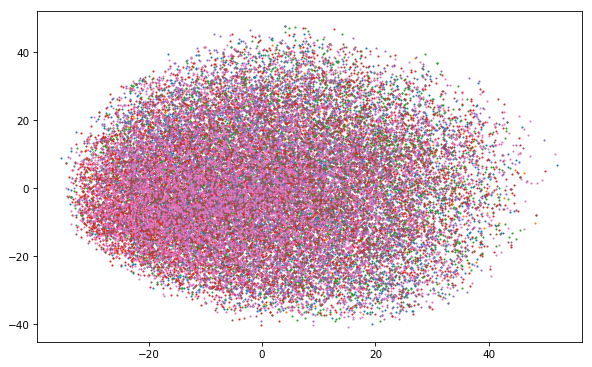

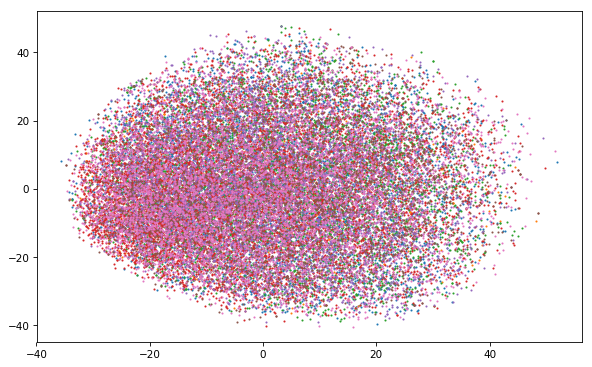

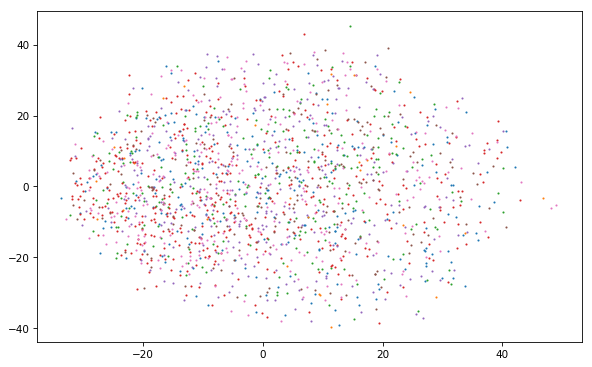

In [24]:
for my_set in sets:
    mm.plot_pca(my_set[0], my_set[1], dpi=75)

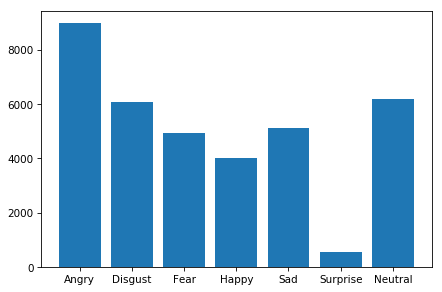

In [25]:
# Entire dataset
counts = collections.Counter(y)
nbs = []
for k in counts:
    nbs.append(counts[k])
    
plt.figure(dpi=75)
plt.bar(num_to_class, nbs)
plt.tight_layout()
plt.savefig('DataBarPlot.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

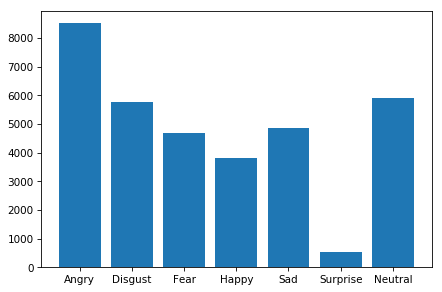

In [26]:
# Train set
counts = collections.Counter(y_train)
train_nbs = []
for k in counts:
    train_nbs.append(counts[k])
    
plt.figure(dpi=75)
plt.bar(num_to_class, train_nbs)
plt.tight_layout()
plt.savefig('TrainBarPlot.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

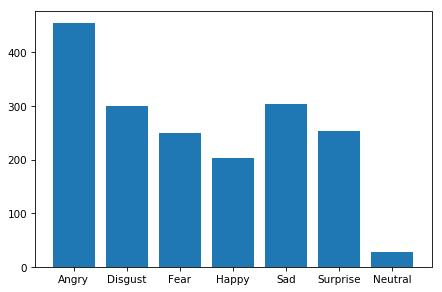

In [27]:
# Test set
counts = collections.Counter(y_test)
test_nbs = []
for k in counts:
    test_nbs.append(counts[k])
    
plt.figure(dpi=75)
plt.bar(num_to_class, test_nbs)
plt.tight_layout()
plt.savefig('TestBarPlot.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

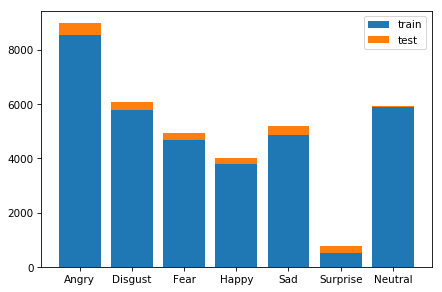

In [28]:
plt.figure(dpi=75)
plt.bar(num_to_class, train_nbs, label='train')
plt.bar(num_to_class, test_nbs, label='test', bottom=train_nbs)
plt.legend()
plt.tight_layout()
plt.savefig('TrainTestBarPlot.pdf', bbox_inches='tight', format='pdf', dpi=200)
plt.show()

# Assert

In [29]:
# One-hot encode
if y_train.ndim == 1:
    y_train = mm.one_hot_encode(list(y_train))

if y_test.ndim == 1:
    y_test = mm.one_hot_encode(list(y_test))

In [30]:
# Assert shapes
assert(y_train.shape[1]==NUM_CLASSES)
assert(y_test.shape[1]==NUM_CLASSES)

In [31]:
# Assert std devs
assert(np.isclose(np.round(x_train[0].std(), 3), 1, atol=0.5))
assert(np.isclose(np.round(x_test[0].std(), 3), 1, atol=0.5))

In [32]:
# Assert means
assert(np.isclose(np.round(x_train[0].mean(), 3), 0, atol=0.5))
assert(np.isclose(np.round(x_test[0].mean(), 3), 0, atol=0.5))

In [33]:
# Assert 4D
assert(len(x_train.shape)==4)
assert(len(x_test.shape)==4)

# Model

In [34]:
# Check
print('x_train :', x_train.shape)
print('y_train :', y_train.shape)
print('')
print('x_test  :', x_test.shape)
print('y_test  :', y_test.shape)

x_train : (34081, 28, 28, 3)
y_train : (34081, 7)

x_test  : (1794, 28, 28, 3)
y_test  : (1794, 7)


In [35]:
try:
  model.sess
except NameError:
    pass
else:
    model.sess.close()
tf.reset_default_graph()

# Setup model
model = MyCNN(x_train, 
              y_train, 
              x_test,
              y_test,
              output_dir='./FER_logdir/',
              num_to_class=num_to_class, 
              class_to_num=class_to_num,
              lr=5e-5,
              nb_epochs=50, 
              batch_size_train=30,
              seed=0,
              final_activation='softmax')

# Initialise model
model.create_model()
model.compute_loss()
model.optimizer()
model.set_up_saver()
tf.initialize_all_variables().run(session=model.sess)

# Make path if necessary
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

In [36]:
model.model_variables()

x_train             : (34081, 28, 28, 3)
y_train             : (34081, 7)
x_test              : (1794, 28, 28, 3)
y_test              : (1794, 7)
output_dir          : ./FER_logdir/
lr                  : 5e-05
nb_epochs           : 50
batch_size_train    : 30
seed                : 0
nb_classes          : 7
nb_images           : 34081
nb_train_iterations : 1136
im                  : Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
labels              : Tensor("Placeholder_1:0", shape=(?, 7), dtype=float32)


In [37]:
model.model_summary()

first_layer  : conv2D  - (?, 25, 25, 32)
second_layer : conv2D  - (?, 11, 11, 64)
third_layer  : conv2D  - (?, 4, 4, 128)
fourth_layer : conv2D  - (?, 1, 1, 256)
flattened.   : Flatten - (?, 256)
logits       : Dense   - (?, 7)
preds        : Softmax - (?, 7)


In [38]:
# Train model w/o k-fold cross validation
model.train(verbose=False, cross_k_fold_validation=False)

In [39]:
# Test model w/o k-fold cross validation
model.test()

Test accuracy achieved: 0.477


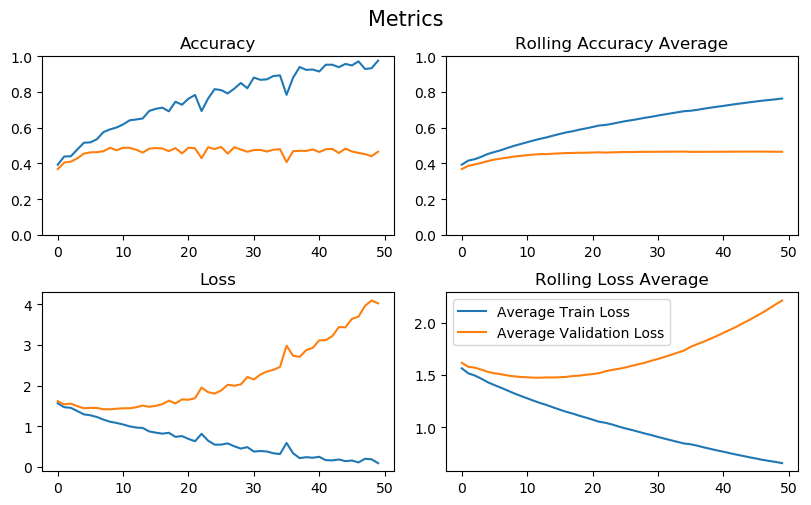

In [40]:
# Plot variables over training and validation w/o k-fold cross validation
mm.plot_metrics(model.accuracy_list, 
                model.losses_list, 
                model.val_accuracy_list, 
                model.val_losses_list,
                save_title='wo_kCV_metrics')

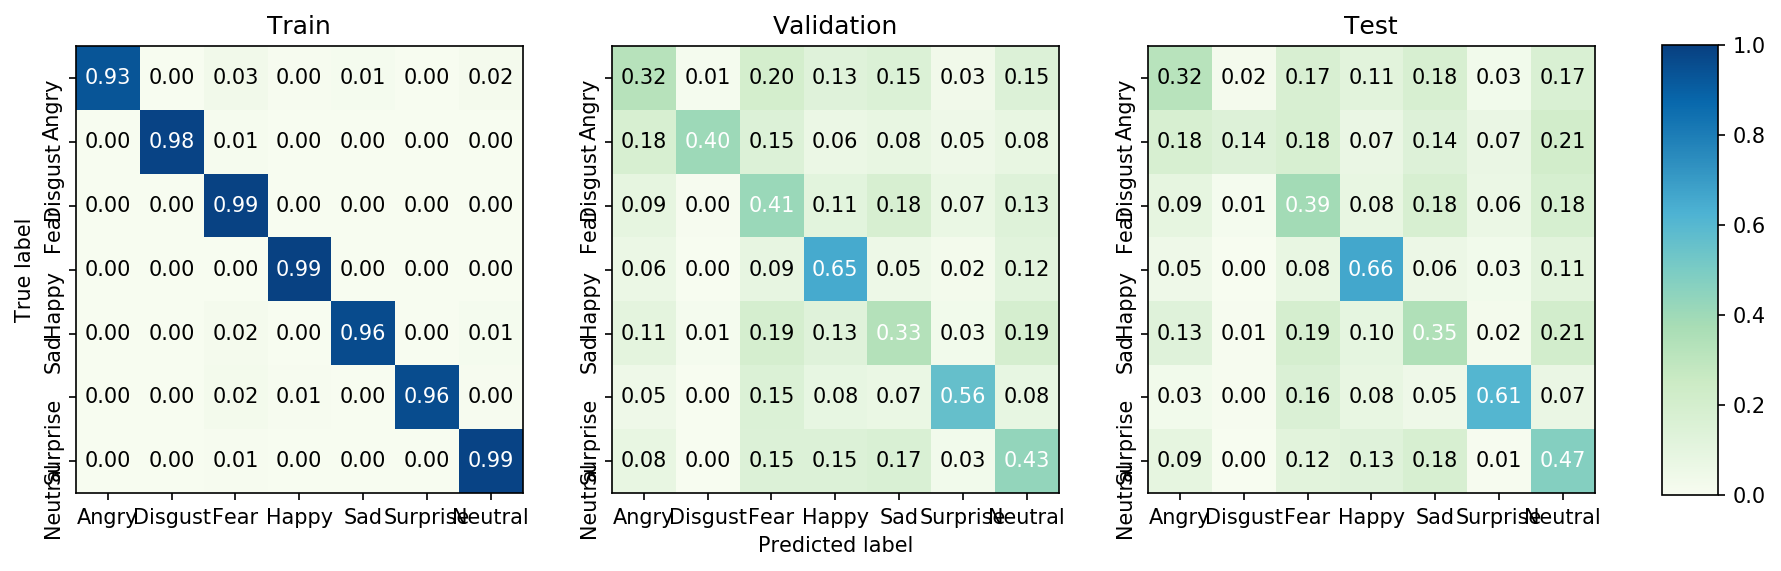

In [41]:
plot_all_confusion_matrices(np.argmax(model.y_train, axis=1), model.preds_list,
                            np.argmax(model.y_val, axis=1), model.preds_list_val,
                            np.argmax(model.y_test, axis=1), model.preds_list_test,
                            np.array(num_to_class), 'CM_wo_kCV', normalize=True)

In [42]:
# Get validation metrics report
report = classification_report(np.argmax(model.y_train, axis=1), 
                               model.preds_list, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.96,0.99,0.93,4226.00
Disgust,0.99,0.99,0.98,457.00
Fear,0.96,0.92,0.99,4373.00
Happy,0.99,0.99,0.99,7677.00
Sad,0.97,0.98,0.96,5212.00
Surprise,0.98,1.00,0.96,3426.00
Neutral,0.98,0.97,0.99,5301.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.97,0.98,0.97,30672.00
weighted avg,0.97,0.98,0.97,30672.00


In [43]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &   support \\
\midrule
Angry        &      0.96 &       0.99 &    0.93 &   4226.00 \\
Disgust      &      0.99 &       0.99 &    0.98 &    457.00 \\
Fear         &      0.96 &       0.92 &    0.99 &   4373.00 \\
Happy        &      0.99 &       0.99 &    0.99 &   7677.00 \\
Sad          &      0.97 &       0.98 &    0.96 &   5212.00 \\
Surprise     &      0.98 &       1.00 &    0.96 &   3426.00 \\
Neutral      &      0.98 &       0.97 &    0.99 &   5301.00 \\
accuracy     &      0.97 &       0.97 &    0.97 &      0.97 \\
macro avg    &      0.97 &       0.98 &    0.97 &  30672.00 \\
weighted avg &      0.97 &       0.98 &    0.97 &  30672.00 \\
\bottomrule
\end{tabular}



In [44]:
# Get validation metrics report
report = classification_report(np.argmax(model.y_val, axis=1), 
                               model.preds_list_val, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.35,0.39,0.32,466.00
Disgust,0.47,0.56,0.40,62.00
Fear,0.36,0.32,0.41,498.00
Happy,0.65,0.64,0.65,856.00
Sad,0.34,0.36,0.33,560.00
Surprise,0.61,0.66,0.56,371.00
Neutral,0.42,0.40,0.43,596.00
accuracy,0.47,0.47,0.47,0.47
macro avg,0.46,0.48,0.44,3409.00
weighted avg,0.47,0.47,0.47,3409.00


In [45]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Angry        &      0.35 &       0.39 &    0.32 &   466.00 \\
Disgust      &      0.47 &       0.56 &    0.40 &    62.00 \\
Fear         &      0.36 &       0.32 &    0.41 &   498.00 \\
Happy        &      0.65 &       0.64 &    0.65 &   856.00 \\
Sad          &      0.34 &       0.36 &    0.33 &   560.00 \\
Surprise     &      0.61 &       0.66 &    0.56 &   371.00 \\
Neutral      &      0.42 &       0.40 &    0.43 &   596.00 \\
accuracy     &      0.47 &       0.47 &    0.47 &     0.47 \\
macro avg    &      0.46 &       0.48 &    0.44 &  3409.00 \\
weighted avg &      0.47 &       0.47 &    0.47 &  3409.00 \\
\bottomrule
\end{tabular}



In [46]:
# Get testing metrics report
report = classification_report(np.argmax(model.y_test, axis=1), 
                               model.preds_list_test, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.36,0.40,0.32,253.00
Disgust,0.19,0.27,0.14,28.00
Fear,0.35,0.31,0.39,250.00
Happy,0.68,0.69,0.66,455.00
Sad,0.35,0.36,0.35,304.00
Surprise,0.66,0.73,0.61,204.00
Neutral,0.43,0.39,0.47,300.00
accuracy,0.48,0.48,0.48,0.48
macro avg,0.43,0.45,0.42,1794.00
weighted avg,0.48,0.49,0.48,1794.00


In [47]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Angry        &      0.36 &       0.40 &    0.32 &   253.00 \\
Disgust      &      0.19 &       0.27 &    0.14 &    28.00 \\
Fear         &      0.35 &       0.31 &    0.39 &   250.00 \\
Happy        &      0.68 &       0.69 &    0.66 &   455.00 \\
Sad          &      0.35 &       0.36 &    0.35 &   304.00 \\
Surprise     &      0.66 &       0.73 &    0.61 &   204.00 \\
Neutral      &      0.43 &       0.39 &    0.47 &   300.00 \\
accuracy     &      0.48 &       0.48 &    0.48 &     0.48 \\
macro avg    &      0.43 &       0.45 &    0.42 &  1794.00 \\
weighted avg &      0.48 &       0.49 &    0.48 &  1794.00 \\
\bottomrule
\end{tabular}



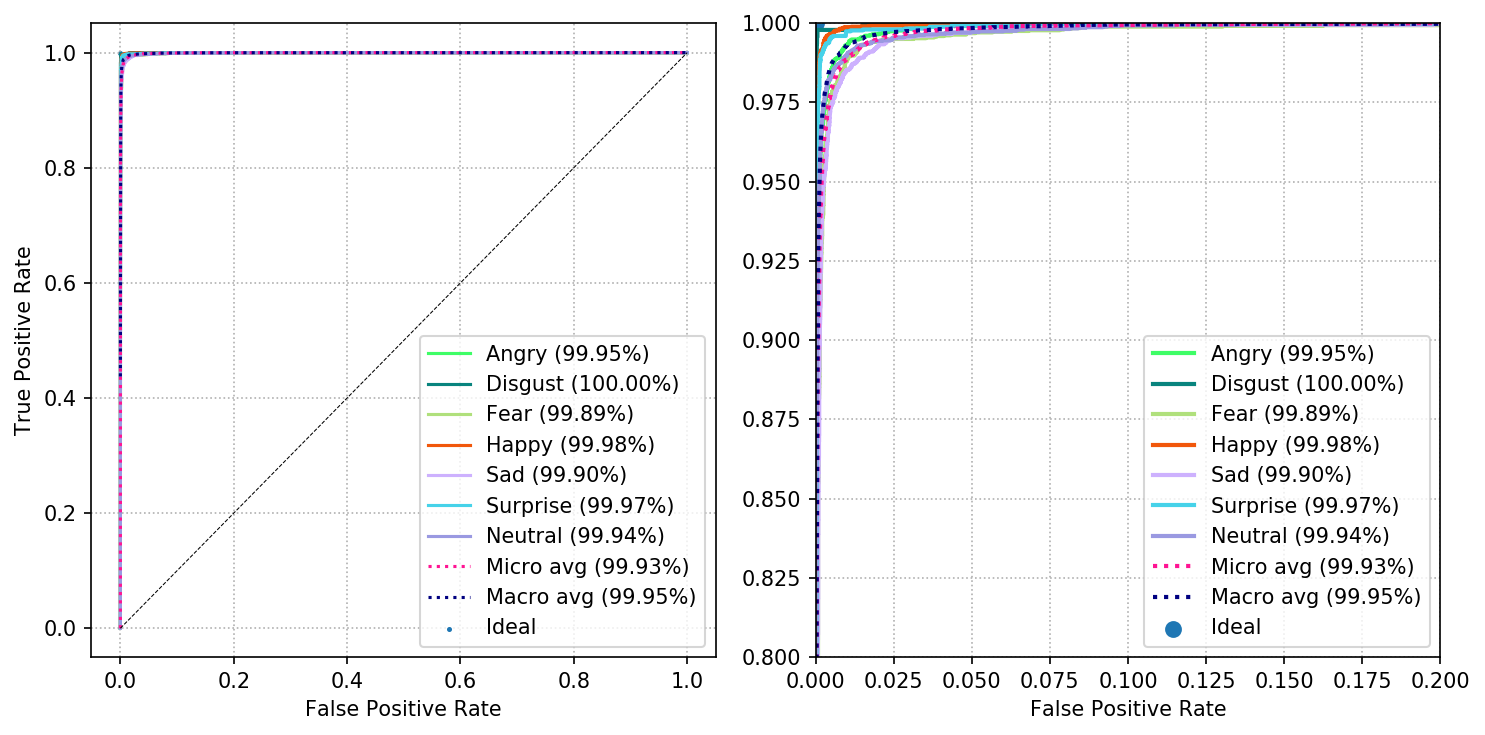

In [48]:
# Train ROC/AUC w/o-cross val
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_train, model.probs_list)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 0.2), ylim=(0.8, 1), seed=5, save_title='TrainROC_wo_kCV')

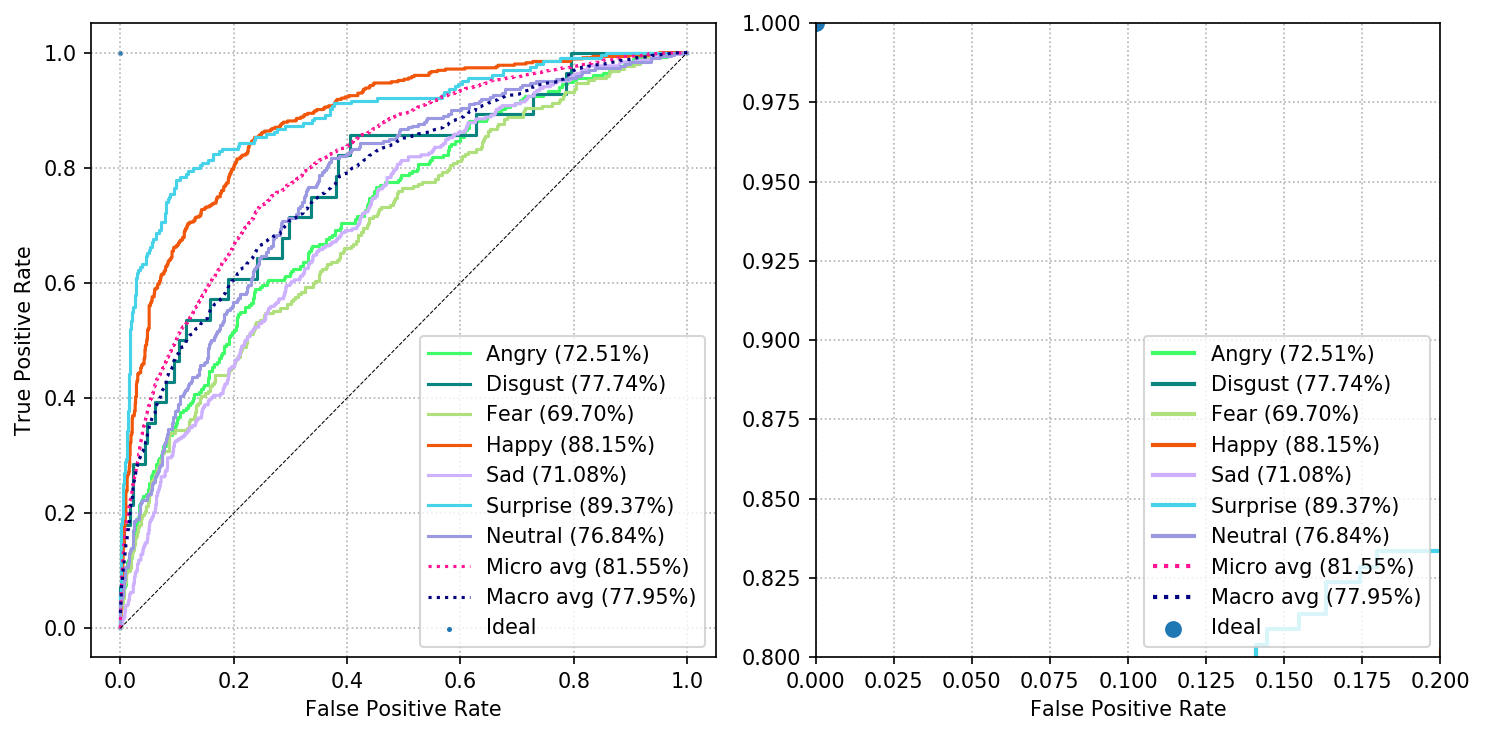

In [49]:
# Train ROC/AUC w/o-cross val
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model.y_test, model.probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 0.2), ylim=(0.8, 1), seed=5, save_title='TestROC_wo_kCV')

In [50]:
model.sess.close()

# W/Cross k.

In [51]:
try:
  sess
except NameError:
    pass
else:
    sess.close()
tf.reset_default_graph()

# Setup model_2
model_2 = MyCNN(x_train[:33150], 
                y_train[:33150], 
                x_test,
                y_test,
                output_dir='./FER_logdir/',
                num_to_class=num_to_class, 
                class_to_num=class_to_num,
                lr=5e-5,
                nb_epochs=50, 
                batch_size_train=30,
                seed=0,
                final_activation='softmax')

# Initialise model_2
model_2.create_model()
model_2.compute_loss()
model_2.optimizer()
model_2.set_up_saver()
tf.initialize_all_variables().run(session=model_2.sess)

# Make path if necessary
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

In [52]:
# Train model w/k-CV
model_2.train(verbose=False, cross_k_fold_validation=True)

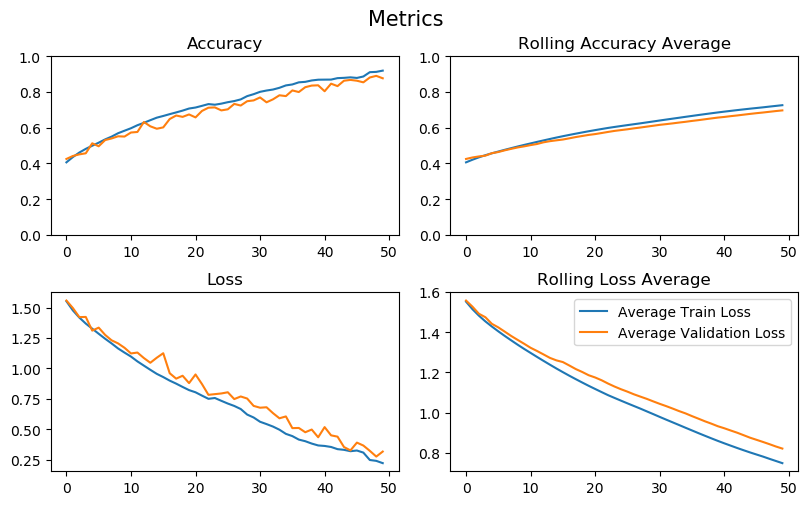

In [53]:
# Plot variables over training and validation w/k-CV
mm.plot_metrics(model_2.accuracy_list, 
                model_2.losses_list, 
                model_2.val_accuracy_list, 
                model_2.val_losses_list,
                save_title='w_kCV_metrics')

In [54]:
# Test model w/k-CV
model_2.test()

Test accuracy achieved: 0.452


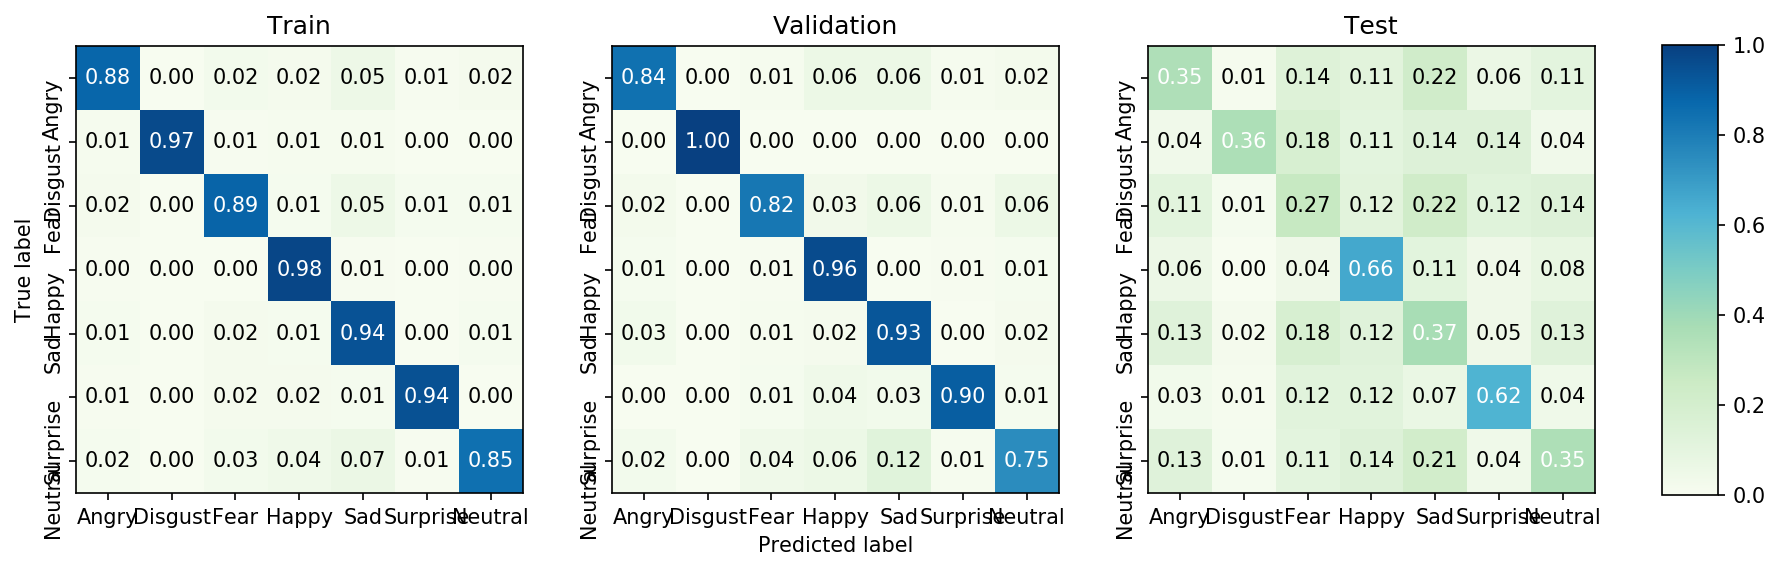

In [55]:
# Plot CMs w/k-CV
plot_all_confusion_matrices(np.argmax(model_2.y_train, axis=1), model_2.preds_list,
                            np.argmax(model_2.y_val, axis=1),   model_2.preds_list_val,
                            np.argmax(model_2.y_test, axis=1),  model_2.preds_list_test,
                            np.array(num_to_class), 'CM_w_kCV', normalize=True)

In [56]:
# Get validation metrics report
report = classification_report(np.argmax(model_2.y_train, axis=1), 
                               model_2.preds_list, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.90,0.93,0.88,4561.00
Disgust,0.95,0.94,0.97,506.00
Fear,0.90,0.90,0.89,4728.00
Happy,0.96,0.94,0.98,8311.00
Sad,0.89,0.84,0.94,5600.00
Surprise,0.95,0.96,0.94,3695.00
Neutral,0.89,0.95,0.85,5749.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.92,0.92,0.92,33150.00
weighted avg,0.92,0.92,0.92,33150.00


In [57]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &   support \\
\midrule
Angry        &      0.90 &       0.93 &    0.88 &   4561.00 \\
Disgust      &      0.95 &       0.94 &    0.97 &    506.00 \\
Fear         &      0.90 &       0.90 &    0.89 &   4728.00 \\
Happy        &      0.96 &       0.94 &    0.98 &   8311.00 \\
Sad          &      0.89 &       0.84 &    0.94 &   5600.00 \\
Surprise     &      0.95 &       0.96 &    0.94 &   3695.00 \\
Neutral      &      0.89 &       0.95 &    0.85 &   5749.00 \\
accuracy     &      0.92 &       0.92 &    0.92 &      0.92 \\
macro avg    &      0.92 &       0.92 &    0.92 &  33150.00 \\
weighted avg &      0.92 &       0.92 &    0.92 &  33150.00 \\
\bottomrule
\end{tabular}



In [58]:
# Get validation metrics report
report = classification_report(np.argmax(model_2.y_val, axis=1), 
                               model_2.preds_list_val, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.86,0.88,0.84,89.00
Disgust,1.00,1.00,1.00,11.00
Fear,0.85,0.89,0.82,89.00
Happy,0.93,0.89,0.96,169.00
Sad,0.85,0.79,0.93,109.00
Surprise,0.92,0.94,0.90,73.00
Neutral,0.81,0.88,0.75,123.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.89,0.90,0.89,663.00
weighted avg,0.88,0.88,0.88,663.00


In [59]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Angry        &      0.86 &       0.88 &    0.84 &    89.00 \\
Disgust      &      1.00 &       1.00 &    1.00 &    11.00 \\
Fear         &      0.85 &       0.89 &    0.82 &    89.00 \\
Happy        &      0.93 &       0.89 &    0.96 &   169.00 \\
Sad          &      0.85 &       0.79 &    0.93 &   109.00 \\
Surprise     &      0.92 &       0.94 &    0.90 &    73.00 \\
Neutral      &      0.81 &       0.88 &    0.75 &   123.00 \\
accuracy     &      0.88 &       0.88 &    0.88 &     0.88 \\
macro avg    &      0.89 &       0.90 &    0.89 &   663.00 \\
weighted avg &      0.88 &       0.88 &    0.88 &   663.00 \\
\bottomrule
\end{tabular}



In [60]:
# Get testing metrics report
report = classification_report(np.argmax(model_2.y_test, axis=1), 
                               model_2.preds_list_test, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.37,0.39,0.35,253.00
Disgust,0.36,0.37,0.36,28.00
Fear,0.27,0.28,0.27,250.00
Happy,0.65,0.64,0.66,455.00
Sad,0.34,0.32,0.37,304.00
Surprise,0.59,0.57,0.62,204.00
Neutral,0.38,0.42,0.35,300.00
accuracy,0.45,0.45,0.45,0.45
macro avg,0.42,0.43,0.43,1794.00
weighted avg,0.45,0.45,0.45,1794.00


In [61]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Angry        &      0.37 &       0.39 &    0.35 &   253.00 \\
Disgust      &      0.36 &       0.37 &    0.36 &    28.00 \\
Fear         &      0.27 &       0.28 &    0.27 &   250.00 \\
Happy        &      0.65 &       0.64 &    0.66 &   455.00 \\
Sad          &      0.34 &       0.32 &    0.37 &   304.00 \\
Surprise     &      0.59 &       0.57 &    0.62 &   204.00 \\
Neutral      &      0.38 &       0.42 &    0.35 &   300.00 \\
accuracy     &      0.45 &       0.45 &    0.45 &     0.45 \\
macro avg    &      0.42 &       0.43 &    0.43 &  1794.00 \\
weighted avg &      0.45 &       0.45 &    0.45 &  1794.00 \\
\bottomrule
\end{tabular}



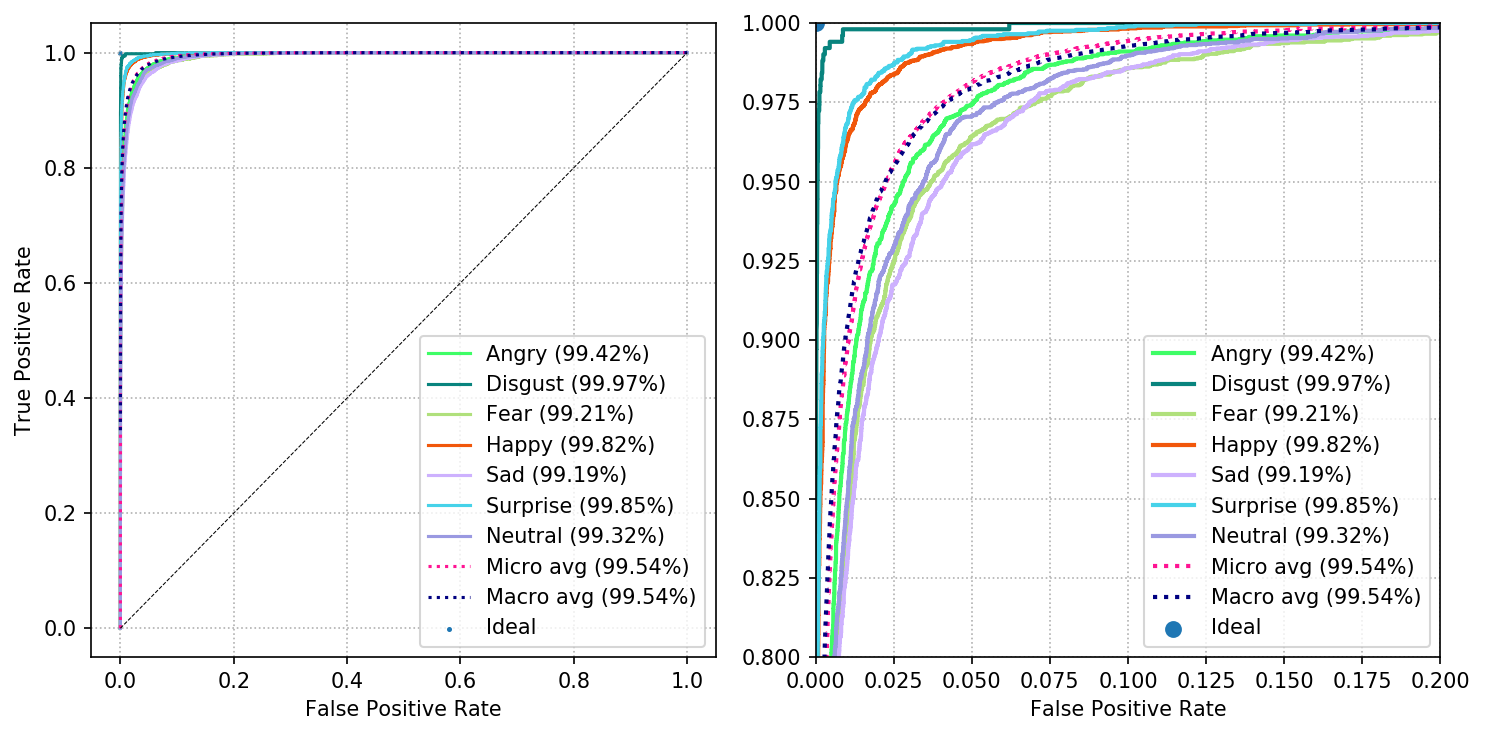

In [62]:
# Train ROC/AUC w/k-cross val
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model_2.y_train, model_2.probs_list)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 0.2), ylim=(0.8, 1), seed=5, save_title='TrainROC_w_kCV')

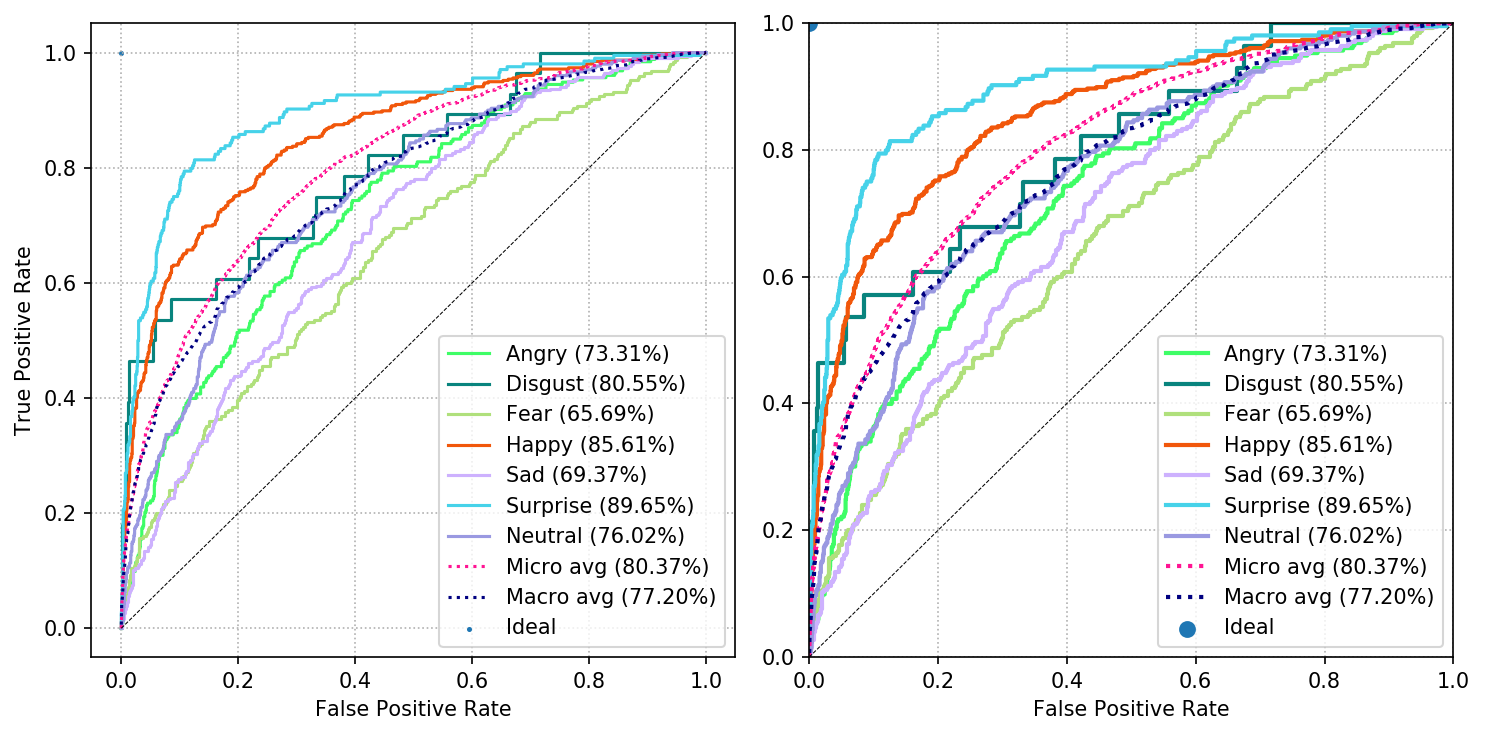

In [63]:
# Test ROC/AUC w/k-cross val
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(model_2.y_test, model_2.probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 1), ylim=(0, 1), seed=5, save_title='TestROC_w_kCV')

In [64]:
model_2.sess.close()

# Model 3

In [65]:
# (Re-)Split
x_train, y_train, x_val, y_val, x_test, y_test = mm.split_train_val_test(x, y)

In [66]:
# One-hot encode
if y_train.ndim == 1:
    y_train = mm.one_hot_encode(list(y_train))
    
if y_val.ndim == 1:
    y_val = mm.one_hot_encode(list(y_val))

if y_test.ndim == 1:
    y_test = mm.one_hot_encode(list(y_test))

In [67]:
# Assert shapes
assert(y_train.shape[1]==NUM_CLASSES)
assert(y_val.shape[1]==NUM_CLASSES)
assert(y_test.shape[1]==NUM_CLASSES)

In [68]:
try:
  sess
except NameError:
    pass
else:
    sess.close()
tf.reset_default_graph()

# Setup model_3
model_3 = MyDeepCNN(x_train,
                    y_train,
                    x_val,
                    y_val,
                    x_test,
                    y_test,
                    output_dir='./FER_logdir/',
                    lr=1e-3,
                    beta_1=0.9,
                    beta_2=0.999,
                    nb_epochs=50,
                    epsilon=1e-7,
                    batch_size=64,
                    seed=0,
                    num_features=64)

# Initialise model_3
model_3.create_model()

# Make path if necessary
if not os.path.exists(model_3.output_dir):
    os.makedirs(model_3.output_dir)

In [69]:
model_3.model_variables()

x_train      : (32287, 28, 28, 3)
y_train      : (32287, 7)
x_val        : (1794, 28, 28, 3)
y_val.       : (1794, 7)
x_test.      : (1794, 28, 28, 3)
y_test.      : (1794, 7)
output_dir   : ./FER_logdir/
lr           : 0.001
beta_1       : 0.9
beta_2       : 0.999
nb_epochs    : 50
epsilon      : 1e-07
batch_size   : 64
seed         : 0
num_features : 64
nb_classes   : 7
nb_images    : 32287


In [70]:
model_3.model_summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)       512       
__________

In [71]:
# Train
model_3.train(verbose=False)

In [72]:
# Test
model_3.test()

Test accuracy achieved: 0.625


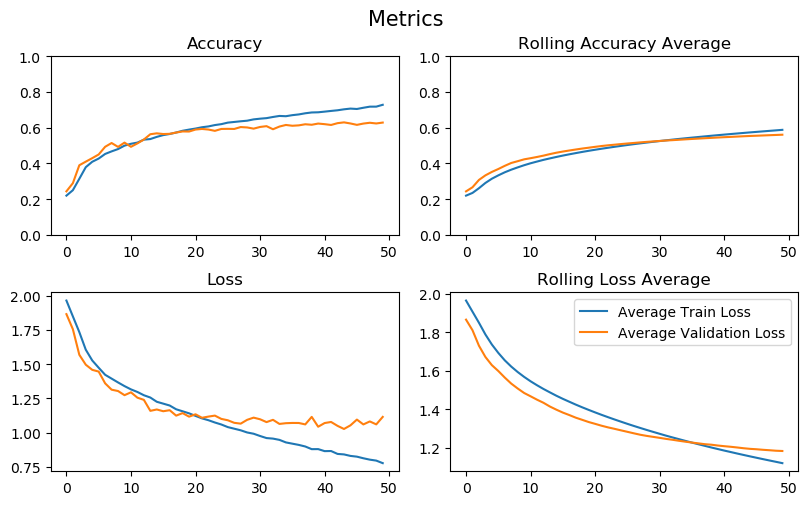

In [73]:
# Plot variables over training and validation - 5e-6 - 100 epochs
mm.plot_metrics(model_3.history.history['acc'], 
                model_3.history.history['loss'], 
                model_3.history.history['val_acc'], 
                model_3.history.history['val_loss'],
                save_title='deepcnn_metrics')


In [74]:
probs_list_train = model_3.model.predict(x_train, batch_size=64)
probs_list_val = model_3.model.predict(x_val, batch_size=64)
probs_list_test = model_3.model.predict(x_test, batch_size=64)

y_hat_train = np.argmax(probs_list_train, axis=1)
y_hat_val = np.argmax(probs_list_val, axis=1)
y_hat_test = np.argmax(probs_list_test, axis=1)

y_real_train = np.argmax(y_train, axis=1)
y_real_val = np.argmax(y_val, axis=1)
y_real_test = np.argmax(y_test, axis=1)

In [75]:
# Get validation metrics report
report = classification_report(y_real_train, 
                               y_hat_train, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.78,0.72,0.85,4441.00
Disgust,0.79,0.74,0.85,489.00
Fear,0.70,0.84,0.61,4608.00
Happy,0.97,0.96,0.97,8095.00
Sad,0.77,0.79,0.76,5458.00
Surprise,0.93,0.95,0.90,3599.00
Neutral,0.85,0.81,0.91,5597.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.83,0.83,0.84,32287.00
weighted avg,0.84,0.85,0.85,32287.00


In [76]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &   support \\
\midrule
Angry        &      0.78 &       0.72 &    0.85 &   4441.00 \\
Disgust      &      0.79 &       0.74 &    0.85 &    489.00 \\
Fear         &      0.70 &       0.84 &    0.61 &   4608.00 \\
Happy        &      0.97 &       0.96 &    0.97 &   8095.00 \\
Sad          &      0.77 &       0.79 &    0.76 &   5458.00 \\
Surprise     &      0.93 &       0.95 &    0.90 &   3599.00 \\
Neutral      &      0.85 &       0.81 &    0.91 &   5597.00 \\
accuracy     &      0.85 &       0.85 &    0.85 &      0.85 \\
macro avg    &      0.83 &       0.83 &    0.84 &  32287.00 \\
weighted avg &      0.84 &       0.85 &    0.85 &  32287.00 \\
\bottomrule
\end{tabular}



In [77]:
# Get validation metrics report
report = classification_report(y_real_val, 
                               y_hat_val, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.56,0.48,0.67,251.00
Disgust,0.54,0.55,0.53,30.00
Fear,0.42,0.53,0.35,263.00
Happy,0.84,0.83,0.86,438.00
Sad,0.49,0.53,0.46,314.00
Surprise,0.77,0.83,0.71,198.00
Neutral,0.59,0.55,0.63,300.00
accuracy,0.63,0.63,0.63,0.63
macro avg,0.60,0.61,0.60,1794.00
weighted avg,0.62,0.63,0.63,1794.00


In [78]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Angry        &      0.56 &       0.48 &    0.67 &   251.00 \\
Disgust      &      0.54 &       0.55 &    0.53 &    30.00 \\
Fear         &      0.42 &       0.53 &    0.35 &   263.00 \\
Happy        &      0.84 &       0.83 &    0.86 &   438.00 \\
Sad          &      0.49 &       0.53 &    0.46 &   314.00 \\
Surprise     &      0.77 &       0.83 &    0.71 &   198.00 \\
Neutral      &      0.59 &       0.55 &    0.63 &   300.00 \\
accuracy     &      0.63 &       0.63 &    0.63 &     0.63 \\
macro avg    &      0.60 &       0.61 &    0.60 &  1794.00 \\
weighted avg &      0.62 &       0.63 &    0.63 &  1794.00 \\
\bottomrule
\end{tabular}



In [79]:
# Get validation metrics report
report = classification_report(y_real_test, 
                               y_hat_test, 
                               target_names=class_to_num, 
                               output_dict=True)
my_df = pd.DataFrame.from_dict(report).T.round(2)
my_df

,f1-score,precision,recall,support
Angry,0.51,0.45,0.58,253.00
Disgust,0.45,0.41,0.50,28.00
Fear,0.41,0.54,0.34,250.00
Happy,0.84,0.82,0.86,455.00
Sad,0.50,0.54,0.46,304.00
Surprise,0.78,0.82,0.74,204.00
Neutral,0.59,0.54,0.65,300.00
accuracy,0.62,0.62,0.62,0.62
macro avg,0.58,0.59,0.59,1794.00
weighted avg,0.62,0.63,0.62,1794.00


In [80]:
print(my_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &  recall &  support \\
\midrule
Angry        &      0.51 &       0.45 &    0.58 &   253.00 \\
Disgust      &      0.45 &       0.41 &    0.50 &    28.00 \\
Fear         &      0.41 &       0.54 &    0.34 &   250.00 \\
Happy        &      0.84 &       0.82 &    0.86 &   455.00 \\
Sad          &      0.50 &       0.54 &    0.46 &   304.00 \\
Surprise     &      0.78 &       0.82 &    0.74 &   204.00 \\
Neutral      &      0.59 &       0.54 &    0.65 &   300.00 \\
accuracy     &      0.62 &       0.62 &    0.62 &     0.62 \\
macro avg    &      0.58 &       0.59 &    0.59 &  1794.00 \\
weighted avg &      0.62 &       0.63 &    0.62 &  1794.00 \\
\bottomrule
\end{tabular}



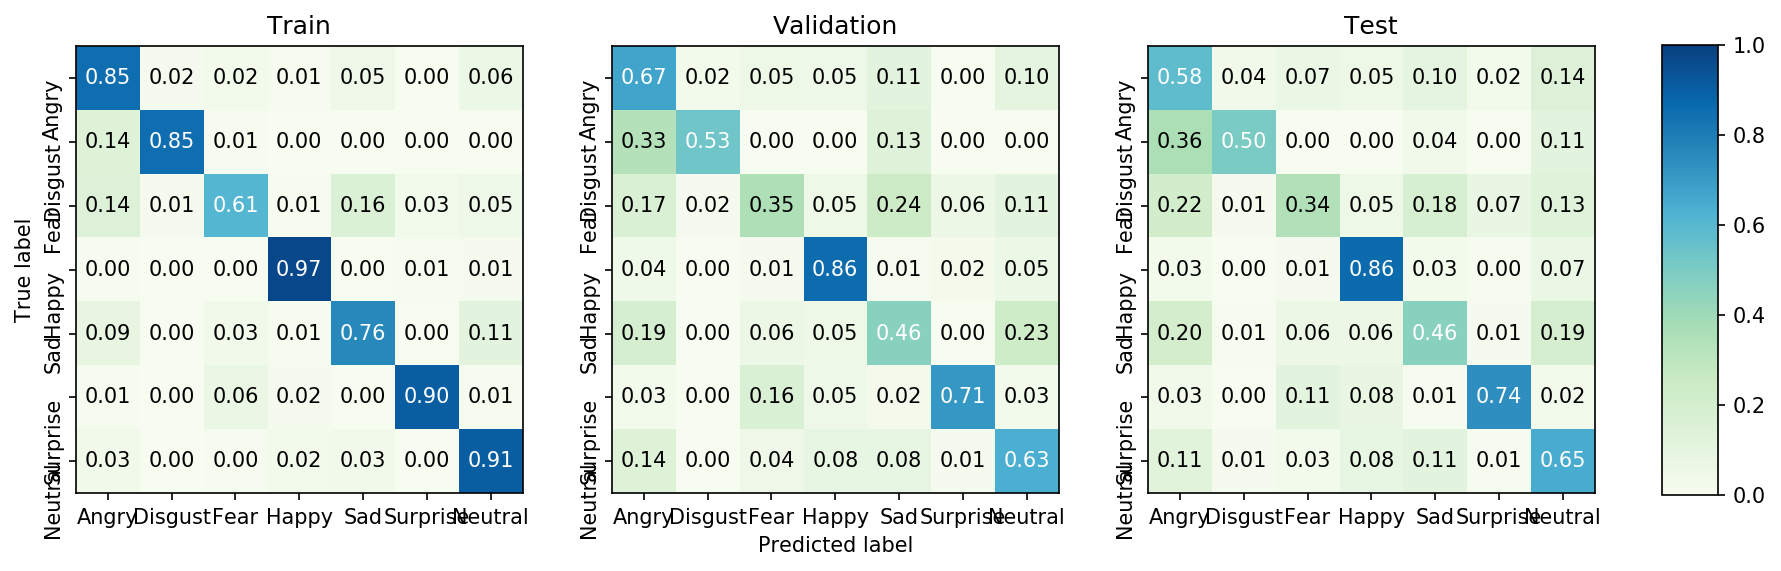

In [81]:
plot_all_confusion_matrices(y_real_train, y_hat_train,
                            y_real_val, y_hat_val,
                            y_real_test, y_hat_test,
                            np.array(num_to_class), 'CM_deepcnn', normalize=True)

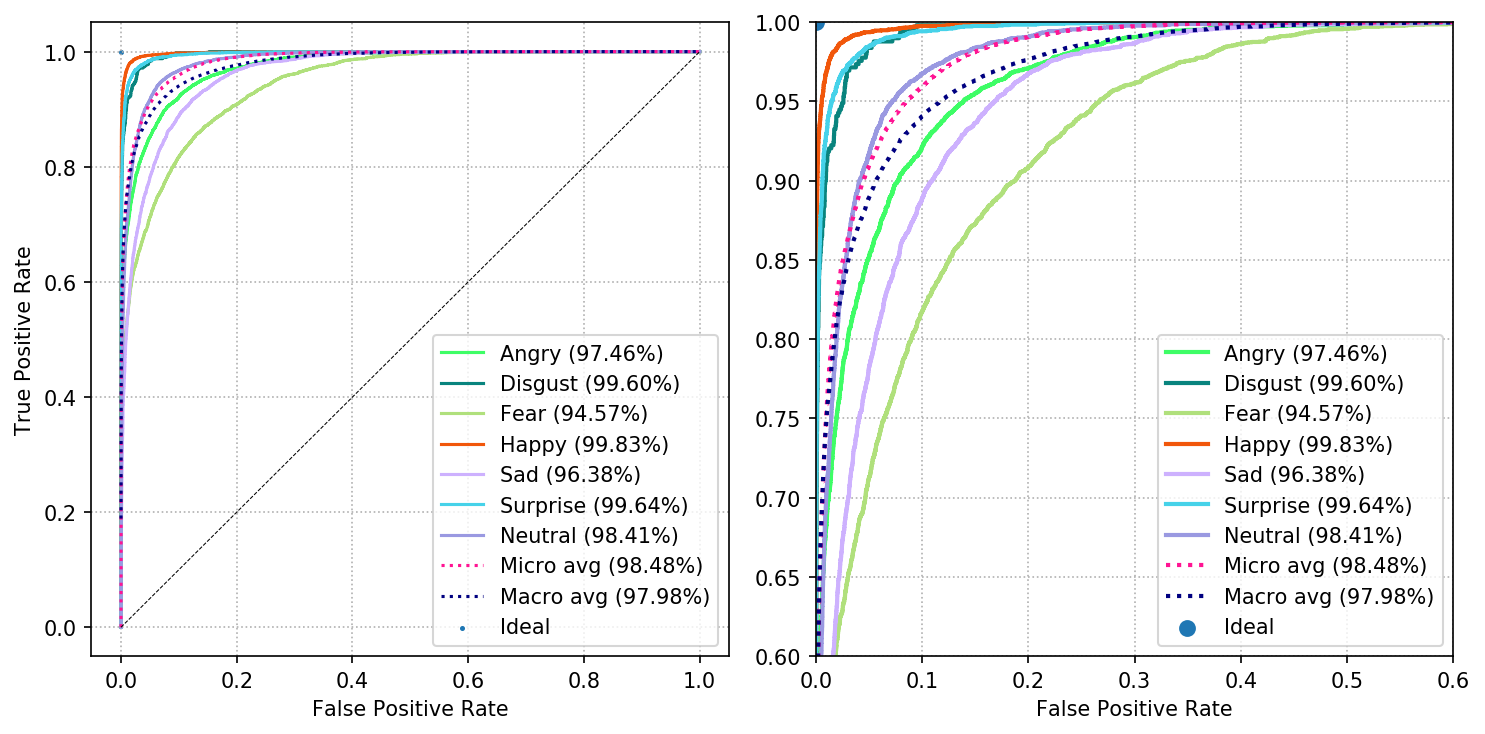

In [82]:
# Train ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(y_train, probs_list_train)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 0.6), ylim=(0.6, 1), seed=5, save_title='TrainROC_deepcnn')

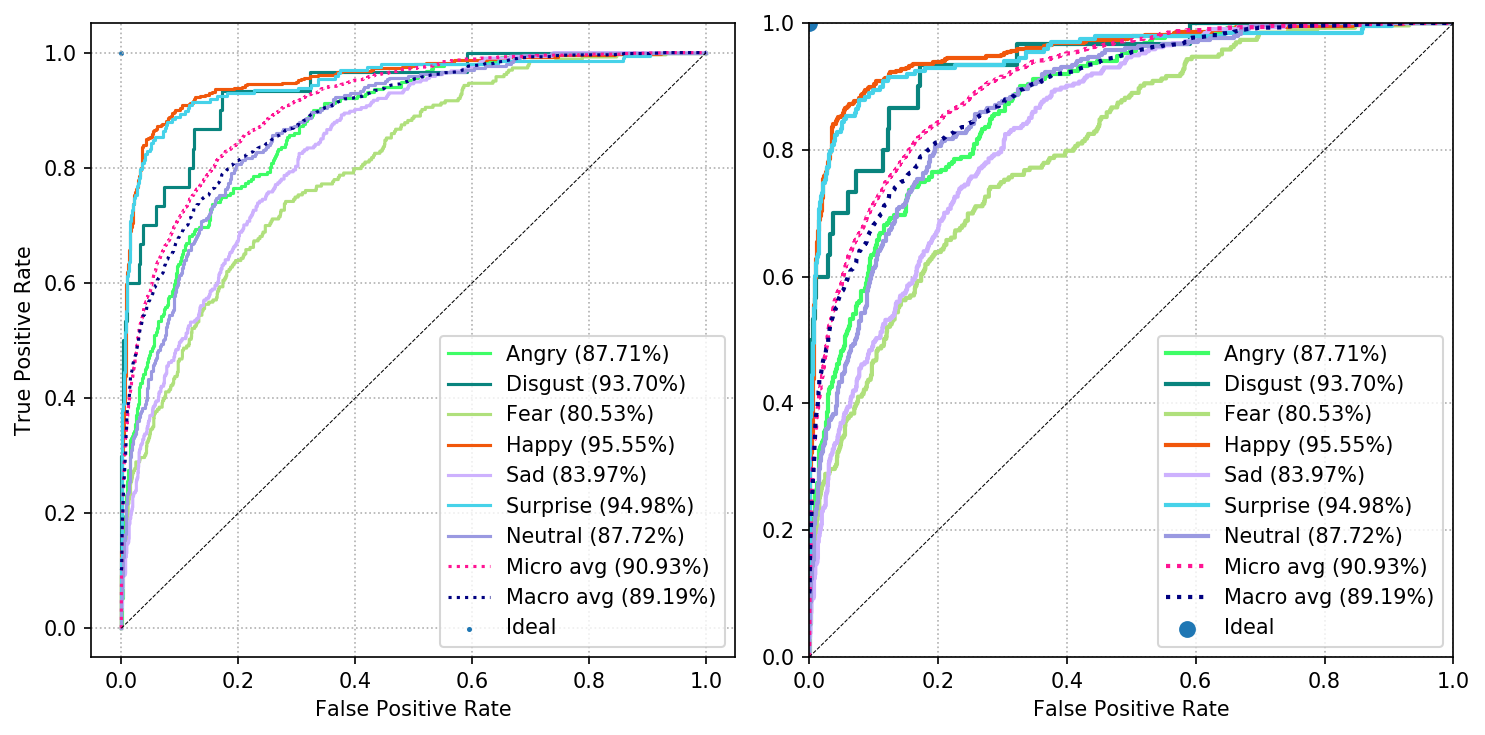

In [83]:
# Val ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(y_val, probs_list_val)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 1), ylim=(0, 1), seed=5, save_title='ValROC_deepcnn')

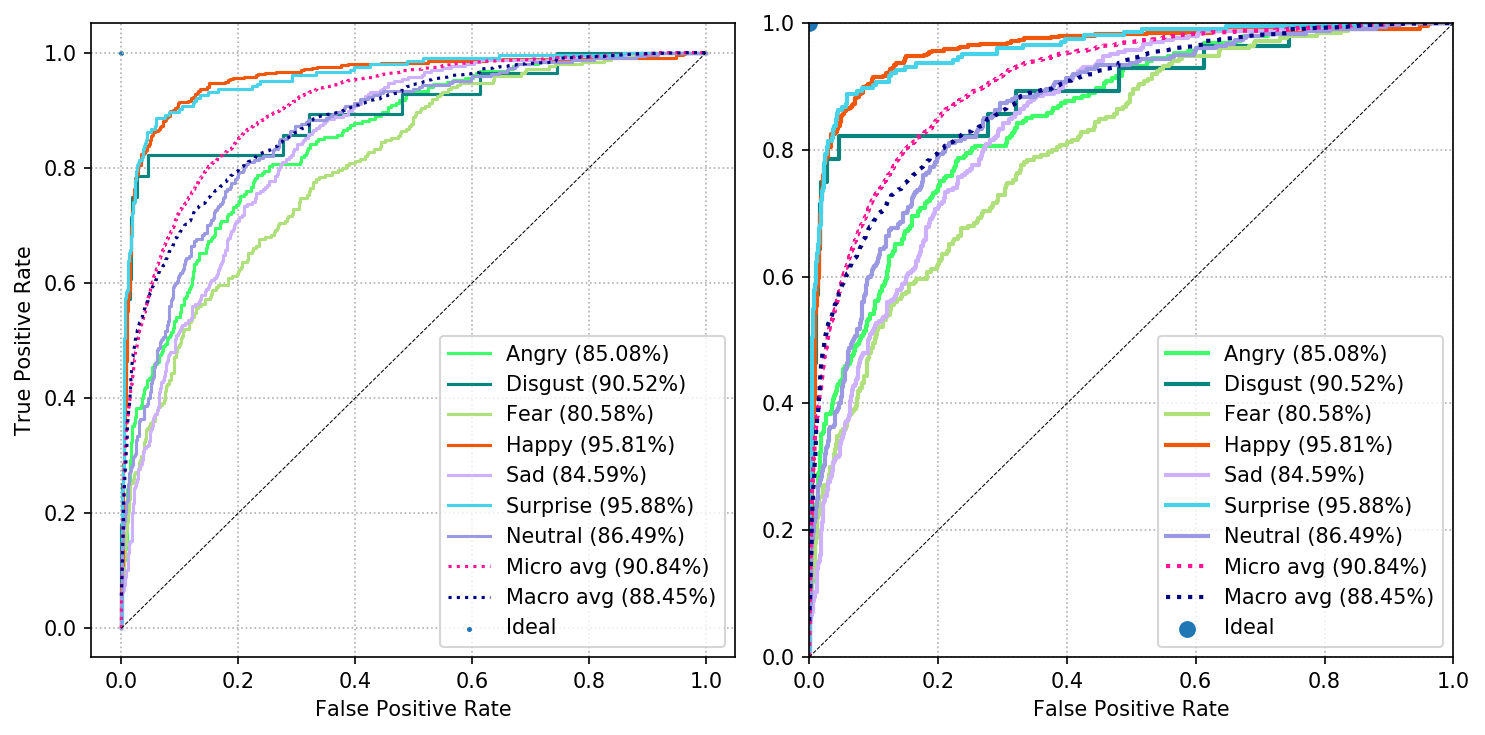

In [84]:
# Test ROC/AUC
fpr, tpr, thresholds, roc_auc = make_fpr_tpr_auc_dicts(y_test, probs_list_test)
plot_roc_auc_curves(fpr, tpr, roc_auc, xlim=(0, 1), ylim=(0, 1), seed=5, save_title='TestROC_deepcnn')

In [85]:
model_3.sess.close()